In [1]:
#importing libraries
import torch
import torch.nn as nn
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import math
import PIL
from torchvision.io import read_image
from torchvision.models import resnet50, ResNet50_Weights

# QUESTION1

C:\Users\Naresh Bandaru\AppData\Roaming\Python\Python310\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid r

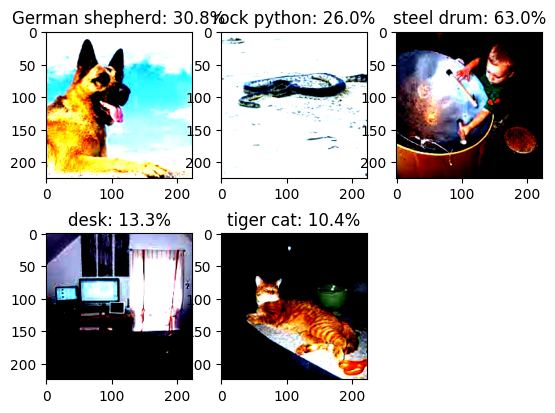

In [2]:
#loading images
img = []
img.append(read_image("dlimages\i1.jpg"))
img.append(read_image("dlimages\i2.jpg"))
img.append(read_image("dlimages\i3.jpg"))
img.append(read_image("dlimages\i4.jpg"))
img.append(read_image("dlimages\i5.jpg"))

# Step 1: Initialize model with the best available weights
weights = ResNet50_Weights.DEFAULT
model = resnet50(weights=weights)
model.eval()

# Step 2: Initialize the inference transforms
preprocess = weights.transforms()

# Step 3: Apply inference preprocessing transforms
batch = []
batch_d = []
for i in range(5):
    batch.append(preprocess(img[i]).unsqueeze(0))
    batch_d.append(torch.einsum("ijk->jki",preprocess(img[i])))

# Step 4: Use the model and print the predicted category
score = []
class_id = []
category_name = []
fig = plt.figure()
for i in range(5):
    prediction = model(batch[i]).squeeze(0).softmax(0)
    class_id.append(prediction.argmax().item())
    score.append(prediction[class_id[i]].item())
    category_name.append(weights.meta["categories"][class_id[i]])
    fig.add_subplot(2,3,i+1)
    plt.imshow(batch_d[i])
    plt.title(f"{category_name[i]}: {100 * score[i]:.1f}%")
plt.show()

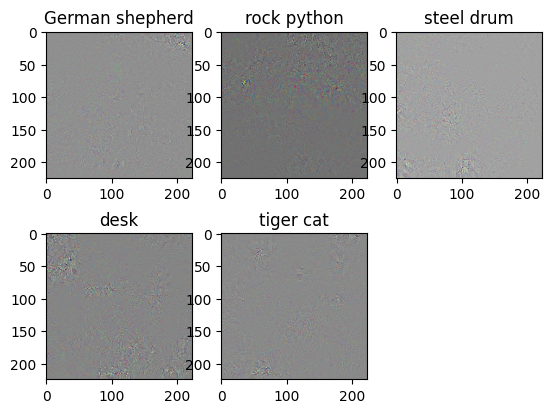

In [3]:
#vanilla backpropogation
batch_grad = []
for i in range(5):
    batch[i].requires_grad = True
    predict = model(batch[i]).squeeze(0)
    zeroes = torch.zeros((1000,))
    zeroes[class_id[i]] = 1
    highest_score = torch.dot(zeroes,predict)
    highest_score.backward()
    grad = torch.einsum("ijk->jki",batch[i].grad.squeeze(0))
    grad = (grad-torch.min(grad))/(torch.max(grad)-torch.min(grad))
    batch_grad.append(grad)
fig = plt.figure()
for i in range(5):
    fig.add_subplot(2,3,i+1)
    plt.imshow(batch_grad[i])
    plt.title(category_name[i])
plt.show()

c:\Users\Naresh Bandaru\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


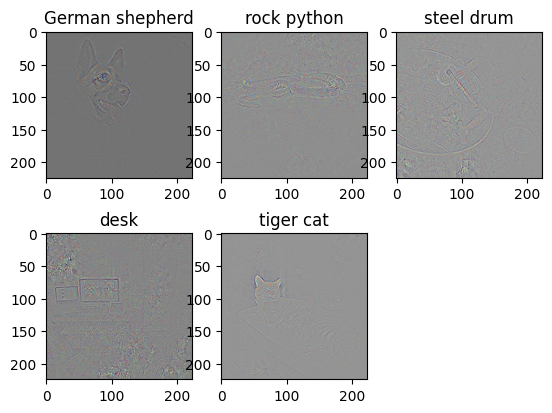

In [4]:
#Guided Backpropogation
def RELU(x):
    zeros = torch.zeros_like(x)
    return torch.maximum(zeros,x)
def relu_backward_hook(module,grad_input,grad_output):
    new_grad_input = RELU(grad_input[0].clone())
    return (new_grad_input,)
for name, module in model.named_modules():
    if isinstance(module, nn.ReLU):
        module.register_backward_hook(relu_backward_hook)
batch_grad_g = []
batch_grad_gn = []
for i in range(5):
    batch[i].requires_grad = True
    predict = model(batch[i]).squeeze(0)
    zeroes = torch.zeros((1000,))
    zeroes[class_id[i]] = 1
    highest_score = torch.dot(zeroes,predict)
    highest_score.backward()
    grad = torch.einsum("ijk->jki",batch[i].grad.squeeze(0))
    batch_grad_g.append(grad)
    grad = (grad-torch.min(grad))/(torch.max(grad)-torch.min(grad))
    batch_grad_gn.append(grad)
fig = plt.figure()
for i in range(5):
    fig.add_subplot(2,3,i+1)
    plt.imshow(batch_grad_gn[i])
    plt.title(category_name[i])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


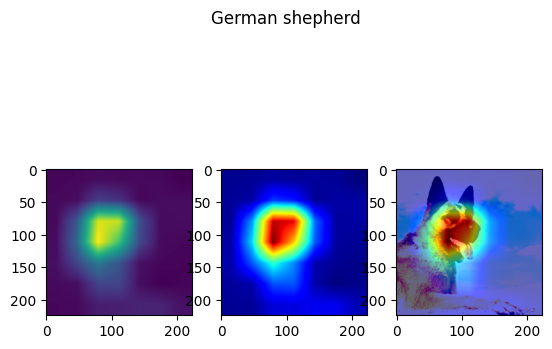

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


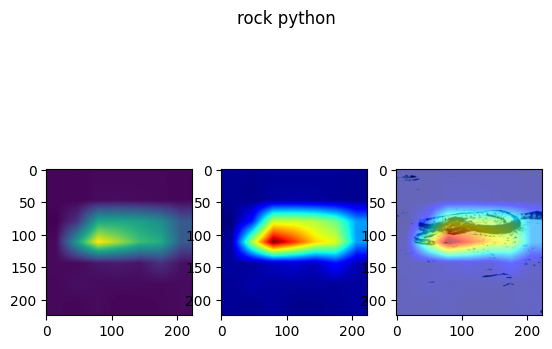

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


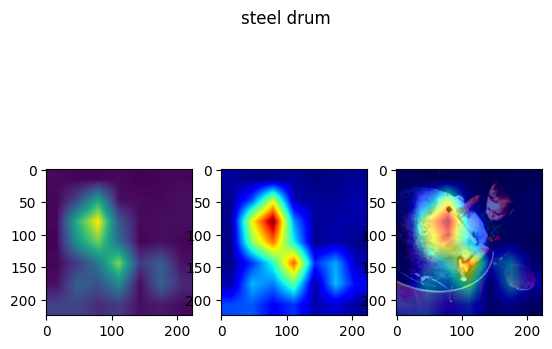

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


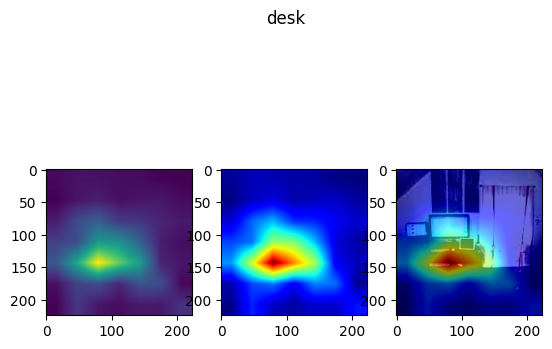

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


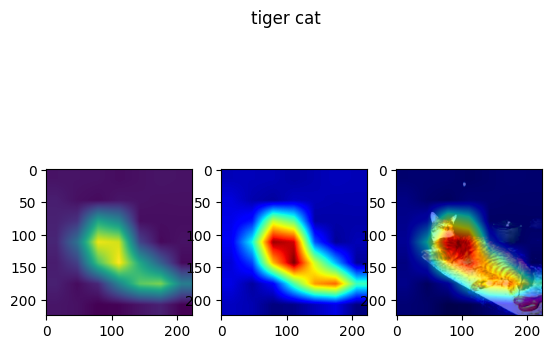

In [5]:
#Class Activation Maps
res50_mod = nn.Sequential(*list(model.children())[:-2])
res50_mod.eval()
for param in res50_mod.parameters():
    param.requires_grad = False
fc_weights = model.state_dict()['fc.weight']
cam = []
for i in range(5):
    batch[i].requires_grad = False
    mod_output = res50_mod(batch[i]).squeeze(0)
    sum = torch.zeros((1,1,7,7))
    for j in range(2048):
        sum[0][0] = sum[0][0] + fc_weights[class_id[i]][j]*mod_output[j]
    cam.append(nn.functional.interpolate(sum,size=[224,224],mode='bilinear')[0][0])
for i in range(5):
    fig = plt.figure()
    fig.suptitle(category_name[i])
    fig.add_subplot(1,3,1)
    plt.imshow(cam[i])
    fig.add_subplot(1,3,2)
    plt.imshow(cam[i],cmap='jet')
    fig.add_subplot(1,3,3)
    plt.imshow(cam[i],cmap='jet')
    plt.imshow(batch_d[i],alpha=0.4)
    plt.show()

torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


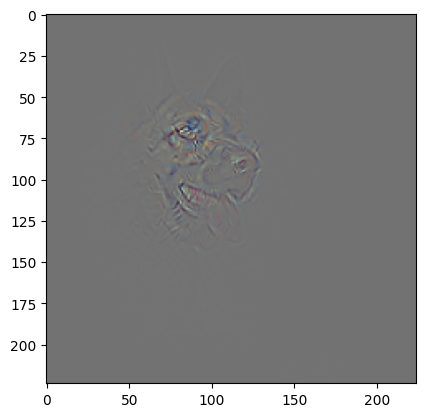

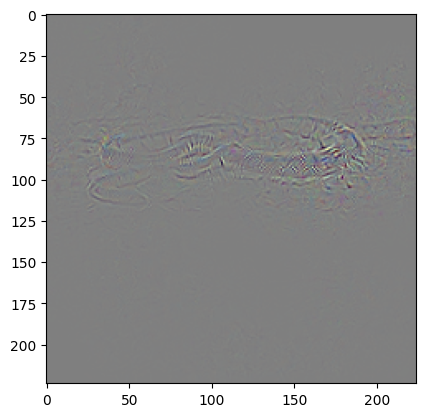

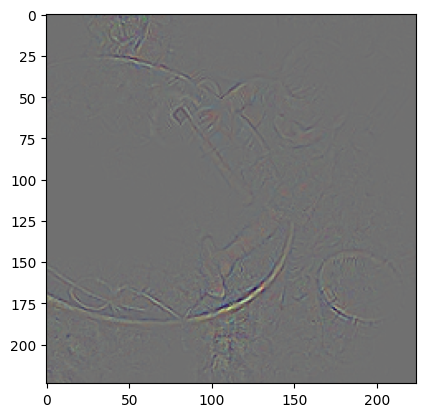

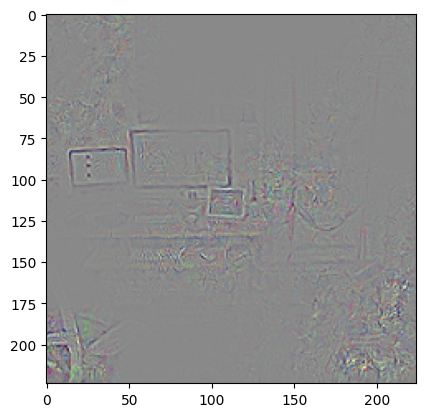

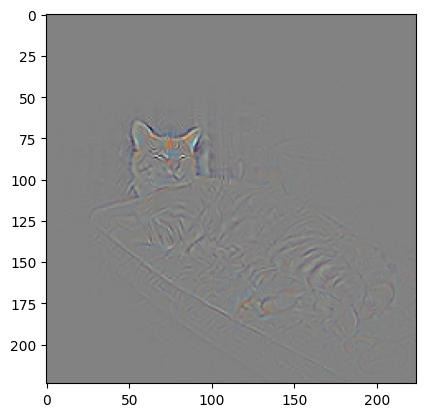

In [6]:
#Guided Grad CAM
global req_grad 
req_grad = []
def backward_hook(module,grad_input,grad_output):
    req_grad.append(grad_input[0])
    return grad_input
for name, module in model.named_modules():
    if (name =='layer4.2.relu'):
        if isinstance(module, nn.ReLU):
            module.register_backward_hook(backward_hook)
grad_cam = []
for i in range(5):
    batch[i].requires_grad = True
    predict = model(batch[i]).squeeze(0)
    zeroes = torch.zeros((1000,))
    zeroes[class_id[i]] = 1
    highest_score = torch.dot(zeroes,predict)
    highest_score.backward()
    weights = req_grad[0].squeeze(0)
    new_w = torch.empty((2048,))
    for k in range(2048):
        new_w[k] = weights[k].mean()
    batch[i].requires_grad = False
    mod_output = res50_mod(batch[i]).squeeze(0)
    sum = torch.zeros((1,1,7,7))
    for j in range(2048):
        sum[0][0] = sum[0][0] + new_w[j]*mod_output[j]
    tbm1 = nn.functional.interpolate(sum,size=[224,224],mode='bilinear')[0][0]
    tbm2 = torch.einsum('ijk->kij',batch_grad_g[i])
    g_cam = tbm1*tbm2
    print(g_cam.shape)
    g_cam = (g_cam-torch.min(g_cam))/(torch.max(g_cam)-torch.min(g_cam))
    grad_cam.append(g_cam)
for i in range(5):
    plt.imshow(torch.einsum('ijk->jki',grad_cam[i]))
    plt.show()

# QUESTION2

In [7]:
def f(x,y):
    return 10*x*x+y*y
input = torch.tensor([2,2])

In [8]:
#lr is learning rate and k is no.of iterations
def vanilla_SGD(w,lr,k):
    min = torch.empty((k+1,2))
    min[0][0] = w[0]
    min[0][1] = w[1]
    for i in range(1,k+1):
        min[i][0] = min[i-1][0]-lr*20*min[i-1][0]
        min[i][1] = min[i-1][1]-lr*2*min[i-1][1]
    return min
output1 = vanilla_SGD(input,0.03,50)

In [9]:
#SGD with momentum
def SGD_momentum(w,p,lr,k):
    v = torch.tensor([0,0])
    min = torch.empty((k+1,2))
    min[0][0] = w[0]
    min[0][1] = w[1]
    for i in range(1,k+1):
        v[0] = p*v[0]+20*min[i-1][0]
        v[1] = p*v[1]+2*min[i-1][1]
        min[i][0] = min[i-1][0]-lr*v[0]
        min[i][1] = min[i-1][1]-lr*v[1]
    return min
output2 = SGD_momentum(input,0.8,0.01,50)

In [10]:
#Nesterov momentum
def nesterov(w,p,lr,k):
    v = torch.tensor([0,0])
    min = torch.empty((k+1,2))
    min[0][0] = w[0]
    min[0][1] = w[1]
    for i in range(1,k+1):
        v[0] = p*v[0]+20*(min[i-1][0]+p*v[0])
        v[1] = p*v[1]+2*(min[i-1][1]+p*v[1])
        min[i][0] = min[i-1][0]-lr*v[0]
        min[i][1] = min[i-1][1]-lr*v[1]
    return min
output3 = nesterov(input,0.02,0.04,50)

In [11]:
#AdaGrad
def adagrad(w,e,lr,k):
    grad_sq = 0
    min = torch.empty((k+1,2))
    min[0][0] = w[0]
    min[0][1] = w[1]
    for i in range(1,k+1):
        grad_sq = grad_sq+400*min[i-1][0]*min[i-1][0]+4*min[i-1][1]*min[i-1][1]
        min[i][0] = min[i-1][0]-lr*20*min[i-1][0]/(math.sqrt(grad_sq)+e)
        min[i][1] = min[i-1][1]-lr*2*min[i-1][1]/(math.sqrt(grad_sq)+e)
    return min
output4 = adagrad(input,0.5,0.9,50)

In [12]:
#RMS prop
def RMS_prop(w,e,p,lr,k):
    grad_sq = 0
    min = torch.empty((k+1,2))
    min[0][0] = w[0]
    min[0][1] = w[1]
    for i in range(1,k+1):
        grad_sq = p*grad_sq+(1-p)*(400*min[i-1][0]*min[i-1][0]+4*min[i-1][1]*min[i-1][1])
        min[i][0] = min[i-1][0]-lr*20*min[i-1][0]/(math.sqrt(grad_sq)+e)
        min[i][1] = min[i-1][1]-lr*2*min[i-1][1]/(math.sqrt(grad_sq)+e)
    return min
output5 = RMS_prop(input,0.69,0.99,0.5,50)

In [13]:
#Enabling animations in notebook
%matplotlib notebook

In [14]:
#visualising convergence path
fig, ax = plt.subplots()
ax.set_xlim(-2,2)
ax.set_ylim(-2,2)
sc1 = ax.scatter([],[],s=3,label='SGD')
sc2 = ax.scatter([],[],s=3,label='SGD_m')
sc3 = ax.scatter([],[],s=3,label='Nesterov')
sc4 = ax.scatter([],[],s=3,label='AdaGrad')
sc5 = ax.scatter([],[],s=3,label='RMS_prop')
ax.legend(loc=4)
def animate(i,output1,output2,output3,output4,output5):
    sc1.set_offsets(np.c_[output1[:i,0],output1[:i,1]])
    sc2.set_offsets(np.c_[output2[:i,0],output1[:i,1]])
    sc3.set_offsets(np.c_[output3[:i,0],output1[:i,1]])
    sc4.set_offsets(np.c_[output4[:i,0],output1[:i,1]])
    sc5.set_offsets(np.c_[output5[:i,0],output1[:i,1]])
animation = FuncAnimation(fig,animate,fargs=(output1,output2,output3,output4,output5,),frames=51,interval=400)
plt.show(animation)

<IPython.core.display.Javascript object>